In [1]:
!nvidia-smi

Wed Nov 12 13:57:33 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti      Off| 00000000:1A:00.0 Off |                  N/A |
| 40%   61C    P2              168W / 250W|   8063MiB / 11264MiB |      8%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:

import sys
#sys.path.append("../../")
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
#os.environ["JAX_PLATFORMS"] = "cuda"  # or: os.environ["JAX_PLATFORM_NAME"]="cuda"
#using GPU, comment out if on CPU?
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '2,3,4,5'
import jax
jax.config.update("jax_disable_jit", False)

jax.config.update("jax_debug_nans", False)
print(jax.lib.xla_bridge.get_backend().platform_version)  # sanity: shows CUDA/cuDNN


/tmp/ipykernel_138367/1069648997.py:15: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  print(jax.lib.xla_bridge.get_backend().platform_version)  # sanity: shows CUDA/cuDNN


PJRT C API
cuda 12030


In [2]:
import diffhydro as dh


eq = dh.equationmanager.EquationManager()
eq.mesh_shape=[256,256,256]

In [3]:
#import numpy as np
U = dh.turbulence.init_turbulent_velocity(eq, 100, 1.0, 1.0,kmax=30,seed=123)
#U = np.load("turb_400x400x400.npy")

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


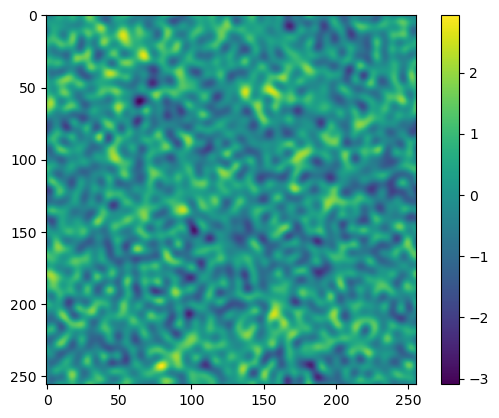

In [4]:
%pylab inline
imshow(U[1][30])
colorbar()
show()

In [5]:
#np.save("turb_400x400x400",U)

In [6]:
eq.cfl

0.4

In [7]:
eq.cfl = 0.6
ss = dh.signal_speed_Rusanov


solver = dh.LaxFriedrichs(equation_manager=eq,signal_speed=ss)

cf = dh.ConvectiveFlux(eq,solver,dh.MUSCL3(limiter="VANLEER"),positivity=True)
#ct = dh.mhd.ConstrainedTransportFlux(eq, solver, dh.MUSCL3(limiter="MINMOD"), positivity=False)

hydro = dh.hydro(n_super_step=800, fluxes=[cf],forces=[],
                 use_mol=True, 
                 integrator="RK2",
                boundary = dh.NoBoundary,pmesh_shape=(2,2,1)) 




In [8]:
import copy
params = {}
#output_first = hydro.evolve_with_callbacks(copy.deepcopy(U),params)

In [9]:
import imageio.v3 as iio

im = np.array(iio.imread('../../data/diffhydro.png'),dtype = np.float32)
print(im.shape)

(600, 600, 4)


In [10]:
from scipy import ndimage
data = 256-im[:,:,0]
data = ndimage.zoom(data,256/600)

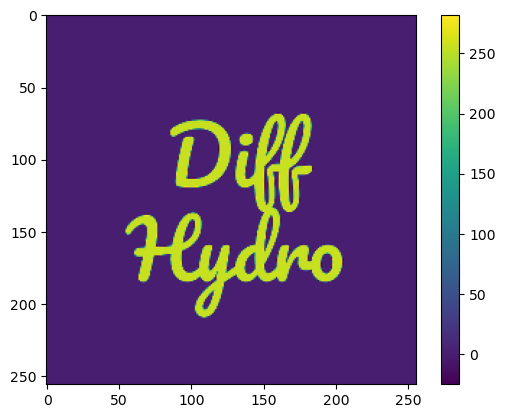

In [11]:
imshow(data)
colorbar()

In [12]:
def init_turbulent_velocity(eq, Lbox, rho0, p0,
                            kmin=1, kmax=3, solenoidal_frac=1.0,
                            pslope=-2.0, target_M=1.0, phases=None, seed=123):
    """
    Initialize turbulent velocity field with optional custom phase information.
    
    Parameters
    ----------
    eq : equation object
        Contains mesh_shape and gamma
    Lbox : float
        Physical size of the box
    rho0, p0 : float
        Background density and pressure
    kmin, kmax : int
        Wavenumber band limits
    solenoidal_frac : float
        Fraction of solenoidal (divergence-free) component (0=compressive, 1=solenoidal)
    pslope : float
        Power law slope for amplitude spectrum
    target_M : float
        Target Mach number
    phases : array-like, optional
        Custom phase information for modes within the band.
        Can be either:
        - (3, nx, ny, nz) array: full phase array (most will be masked)
        - (3, n_band) array: only phases for modes within kmin <= k <= kmax
        If None, random phases are generated using seed.
    seed : int
        Random seed (only used if phases=None)
    
    Returns
    -------
    U : array
        Conservative variables (5, nx, ny, nz)
    """
    nx, ny, nz = eq.mesh_shape
    
    # k-grid (fundamental k0 = 2π/L)
    k0 = 2.0 * jnp.pi / Lbox
    kx = k0 * jnp.fft.fftfreq(nx) * nx
    ky = k0 * jnp.fft.fftfreq(ny) * ny
    kz = k0 * jnp.fft.fftfreq(nz) * nz
    KX, KY, KZ = jnp.meshgrid(kx, ky, kz, indexing="ij")
    K2 = KX**2 + KY**2 + KZ**2
    K = jnp.sqrt(jnp.maximum(K2, 1e-30))
    
    # band-pass mask
    kmag = jnp.sqrt((KX/k0)**2 + (KY/k0)**2 + (KZ/k0)**2)
    band = (kmag >= kmin) & (kmag <= kmax)
    
    # Generate or use custom phases
    if phases is not None:
        phases = jnp.asarray(phases)
        
        # Check if phases are compact (only band elements) or full array
        if phases.shape == (3, nx, ny, nz):
            # Full array provided - use as is
            G = jnp.exp(1j * phases)
        elif len(phases.shape) == 2 and phases.shape[0] == 3:
            # Compact array provided - only band elements
            n_band = phases.shape[1]  # Use the actual size from phases array
            n_band_expected = jnp.sum(band)
         #   if n_band != n_band_expected:
         #       raise ValueError(f"phases has {n_band} elements but band has {n_band_expected} modes")
            
            # Create full complex array and fill in band elements
            G = jnp.zeros((3, nx, ny, nz), dtype=jnp.complex64)
            for i in range(3):
                # Create full array from compact phases
                G_i_flat = jnp.zeros(nx * ny * nz, dtype=jnp.complex64)
                # Flatten band mask and find indices where it's True
                band_flat = band.ravel()
                # Use size parameter to make it JIT-compatible
                indices = jnp.where(band_flat, size=n_band, fill_value=0)[0]
                # Compute phase values
                phase_values = jnp.exp(1j * phases[i])
                # Place phase values at band locations
                G_i_flat = G_i_flat.at[indices].set(phase_values)
                # Reshape back to 3D
                G_i = G_i_flat.reshape(nx, ny, nz)
                G = G.at[i].set(G_i)
        else:
            raise ValueError(f"phases must have shape (3, {nx}, {ny}, {nz}) or (3, n_band), got {phases.shape}")
    else:
        # Original random generation
        key = jax.random.PRNGKey(seed)
        def rand_complex(k):
            a = jax.random.normal(k, (nx, ny, nz))
            b = jax.random.normal(jax.random.split(k)[0], (nx, ny, nz))
            return a + 1j*b
        
        g1 = rand_complex(key); key = jax.random.split(key)[0]
        g2 = rand_complex(key); key = jax.random.split(key)[0]
        g3 = rand_complex(key)
        G = jnp.stack([g1, g2, g3], axis=0)
    
    # amplitude spectrum ~ k^{pslope}
    Amp = (K**(0.5*pslope)) * band
    Amp = Amp / jnp.sqrt(jnp.mean(Amp**2) + 1e-30)  # stabilize scaling
    
    # project to solenoidal/compressive mix
    # tensors per k: P = I - kk^T/k^2, C = kk^T/k^2
    kk_over_k2 = jnp.stack([KX, KY, KZ], 0) / jnp.maximum(K, 1e-30)
    C = jnp.einsum("i...,j...->ij...", kk_over_k2, kk_over_k2)
    I = jnp.eye(3)[:, :, None, None, None]
    P = I - C
    zeta = solenoidal_frac
    Proj = zeta * P + (1.0 - zeta) * C
    
    Uhat = jnp.einsum("ij...,j...->i...", Proj, G) * Amp
    
    # enforce Hermitian symmetry for real IFFT
    u = jnp.fft.ifftn(Uhat, axes=(1,2,3)).real  # shape (3, nx, ny, nz)
    
    # normalize to target Mach
    rho = rho0 * jnp.ones((nx, ny, nz))
    p = p0 * jnp.ones_like(rho)
    cs = jnp.sqrt(eq.gamma * p / rho)
    urms = jnp.sqrt(jnp.mean(jnp.sum(u**2, axis=0)))
    alpha = (target_M * jnp.mean(cs)) / (urms + 1e-30)
    v = alpha * u
    
    # fill conservatives (Euler: U=[rho, rho*u, rho*v, rho*w, E])
    U = jnp.zeros((5, nx, ny, nz))
    U = U.at[0].set(rho)
    U = U.at[1].set(rho * v[0]); U = U.at[2].set(rho * v[1]); U = U.at[3].set(rho * v[2])
    E_th = p / (eq.gamma - 1.0)
    E_kin = 0.5 * rho * (v**2).sum(axis=0)
    U = U.at[4].set(E_th + E_kin)
    
    return U


# Helper functions for working with compact phase arrays
def extract_band_phases(v, Lbox, kmin=1, kmax=3):
    """
    Extract only the non-zero band phase information from a velocity field.
    
    Parameters
    ----------
    v : array
        Velocity field with shape (3, nx, ny, nz)
    Lbox : float
        Physical size of the box
    kmin, kmax : int
        Wavenumber band limits
        
    Returns
    -------
    phases : array
        Compact phase information with shape (3, n_band), values in [0, 2π)
    band_mask : array
        Boolean mask indicating which k-space elements are in the band
    """
    nx, ny, nz = v.shape[1:]
    
    # Compute band mask
    k0 = 2.0 * jnp.pi / Lbox
    kx = k0 * jnp.fft.fftfreq(nx) * nx
    ky = k0 * jnp.fft.fftfreq(ny) * ny
    kz = k0 * jnp.fft.fftfreq(nz) * nz
    KX, KY, KZ = jnp.meshgrid(kx, ky, kz, indexing="ij")
    kmag = jnp.sqrt((KX/k0)**2 + (KY/k0)**2 + (KZ/k0)**2)
    band = (kmag >= kmin) & (kmag <= kmax)
    
    # FFT of velocity field
    vhat = jnp.fft.fftn(v, axes=(1, 2, 3))
    
    # Extract phases only for band elements
    phases_full = jnp.angle(vhat)
    phases_compact = jnp.array([phases_full[i][band] for i in range(3)])
    
    # Ensure phases are in [0, 2π) range
    phases_compact = jnp.mod(phases_compact, 2.0 * jnp.pi)
    
    return phases_compact, band


def get_band_size(mesh_shape, kmin=1, kmax=3):
    """
    Calculate how many k-space modes are in the band.
    
    Parameters
    ----------
    mesh_shape : tuple
        (nx, ny, nz)
    kmin, kmax : int
        Wavenumber band limits
        
    Returns
    -------
    n_band : int
        Number of modes in the band
    """
    nx, ny, nz = mesh_shape
    kx = jnp.fft.fftfreq(nx) * nx
    ky = jnp.fft.fftfreq(ny) * ny
    kz = jnp.fft.fftfreq(nz) * nz
    KX, KY, KZ = jnp.meshgrid(kx, ky, kz, indexing="ij")
    kmag = jnp.sqrt(KX**2 + KY**2 + KZ**2)
    band = (kmag >= kmin) & (kmag <= kmax)
    return jnp.sum(band)

In [13]:
import jax.numpy as jnp
UI = init_turbulent_velocity(eq, 100, 1.0, 1.0, kmax=30, seed=123)

# Extract velocity from conservative variables
rho = UI[0]
v = UI[1:4] / rho

# Extract phases from velocity
phases, band_mask = extract_band_phases(v, 100, kmax=30)

# Use the compact phases
UIp = init_turbulent_velocity(eq, 100, 1.0, 1.0, kmax=30, seed=123, phases=phases)


KeyboardInterrupt



In [14]:
@jax.jit
def forward_model(array):
    Uu2 = init_turbulent_velocity(eq, 100, 1.0, 1.0, kmax=30, seed=123, phases=array)
    output = hydro.evolve_memory_efficient(Uu2,{})
    return output[0]

In [15]:
fff = forward_model(phases)

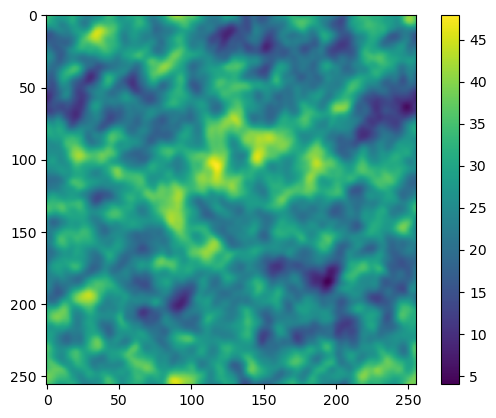

In [16]:
imshow(fff[0].sum(axis=0)-230)
colorbar()

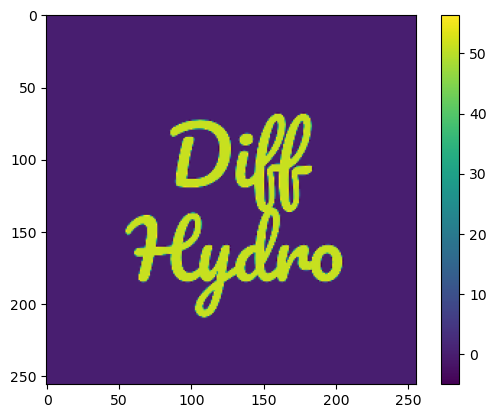

In [17]:
imshow(data/5)
colorbar()

In [18]:
@jax.jit
def likelihood(array):
    field = forward_model(array)
    return jnp.sum((data/5 - (field[0].sum(axis=0)-230))**2.0)

In [19]:
likelihood(phases)

Array(44631256., dtype=float32)

In [20]:
vag = jax.value_and_grad(likelihood)

In [21]:
vv = vag(phases)

In [22]:
params = phases

In [ ]:
import optax
tx = optax.adam(learning_rate=1E-2)
opt_state = tx.init(params)
loss_grad_fn = vag

for i in range(1001):
    print(i)
    loss_val, grads = loss_grad_fn(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    if i % 1 == 0:
        print('Loss step {}: '.format(i), loss_val)


0
Loss step 0:  44631256.0
1
